In [186]:
import numpy as np
import joblib

(1797, 64)


<Figure size 432x288 with 0 Axes>

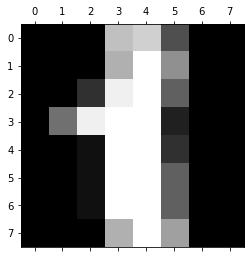

In [64]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
%matplotlib inline
digits = load_digits()
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[1])
plt.show()

In [65]:
X = digits.data
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [66]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(X)
X

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

In [67]:
y = digits.target
y

array([0, 1, 2, ..., 8, 9, 8])

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)

(1257, 64)


In [69]:
input_size = 8 * 8
hidden_size = 30
output_size = 10


In [290]:
class NeuralNetworkClassifier:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        #  инициализация Ксавьера
        # “normal” (Gaussian) distribution of mean 0 and variance  (2 / layer_size) ** 0.5
        self.params['W1'] = (((2 / input_size) ** 0.5) * np.random.randn(input_size, hidden_size))
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = (((2 / hidden_size) ** 0.5) * np.random.randn(hidden_size, output_size))
        self.params['b2'] = np.zeros(output_size)
    
    def forward_pass(self, W1, b1, W2, b2):
        l1 = X.dot(W1) + b1
        l1[l1 < 0] = 0
        l2 = l1.dot(W2) + b2
        exp_scores = np.exp(l2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return l1, probs, exp_scores
    
    def backward_pass(self, probs, l1, W1, W2, reg):
        grads = {}
        probs[range(X.shape[0]),y] -= 1
        dW2 = np.dot(l1.T, probs)
        dW2 /= X.shape[0]
        dW2 += reg * W2
        grads['W2'] = dW2
        grads['b2'] = np.sum(probs, axis=0, keepdims=True) / X.shape[0]
        delta = probs.dot(W2.T)
        delta = delta * (l1 > 0)
        grads['W1'] = np.dot(X.T, delta)/ X.shape[0] + reg * W1
        grads['b1'] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]
        return grads
    
    def calculate_loss(self, W1, W2, reg, probs):
        W1_r = 0.5 * reg * np.sum(W1 * W1)
        W2_r = 0.5 * reg * np.sum(W2 * W2)
        loss = -np.sum(np.log(probs[range(y.shape[0]), y]))/ X.shape[0] + W1_r + W2_r
        return loss
        
    # подсчет значения функции потерь с учетом L2 регуляризации и градиента
    def loss(self, X, y=None, reg=0.0):
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
      
        # forward pass
        l1, probs, exp_scores = self.forward_pass(W1, b1, W2, b2)

        # loss
        loss = self.calculate_loss(W1, W2, reg, probs)

        # backward pass
        grads = self.backward_pass(probs, l1, W1, W2, reg)
        
        return loss, grads

    def train(self, X, y,
            learning_rate=0.1, learning_rate_decay=0.95,
            reg=0.001, num_iters=50000,
            batch_size=50, verbose=False):
    
        loss_history = []
        train_acc_history = []

        for it in range(num_iters):
            # batch selection
            indexes = np.random.choice(X.shape[0], batch_size, replace=True)
            X_batch = X[indexes]
            y_batch = y[indexes]

            loss, grads = self.loss(X_batch, y_batch, reg=reg)
            loss_history.append(loss)

            # Update weights
            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1'][0]
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2'][0]
            
            if it % 100 == 0:
                if verbose:
                    print(f'iteration {it}: loss {loss}')
                train_acc = (self.predict(X_batch)==y_batch).mean()
                train_acc_history.append(train_acc)
                learning_rate *= learning_rate_decay
        
        stats = {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            }
        return stats
    
    def predict(self, X):
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        l1 = X.dot(W1) + b1
        l1[l1 < 0] = 0
        l2 = l1.dot(W2) + b2
        exp_scores = np.exp(l2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        y_pred = np.argmax(probs, axis=1)
        return y_pred

    def predict_one(self, X):
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        l1 = X.dot(W1) + b1
        l1[l1 < 0] = 0
        l2 = l1.dot(W2) + b2
        exp_scores = np.exp(l2)        
        y_pred = np.argmax(exp_scores)
        return y_pred
    
    def dump_data(self):
        classifier = self.params
        joblib.dump(classifier, 'toporov_11601_nn_dicts.pkl')

    def load_data(self, filename='toporov_11601_nn_dicts.pkl'):
        try:
            classifier = joblib.load(filename)
            self.params = classifier
        except Exception as e:
            print(str(e))

In [291]:
net = NeuralNetworkClassifier(input_size, hidden_size, output_size)

In [292]:
stats = net.train(X_train, y_train, num_iters=1000, verbose=False)

In [293]:
y_pred = net.predict(X_test)
# print(y_pred)

In [294]:
from sklearn.metrics import accuracy_score
# print(y_test)

In [295]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9944444444444445

Text(0, 0.5, 'Loss')

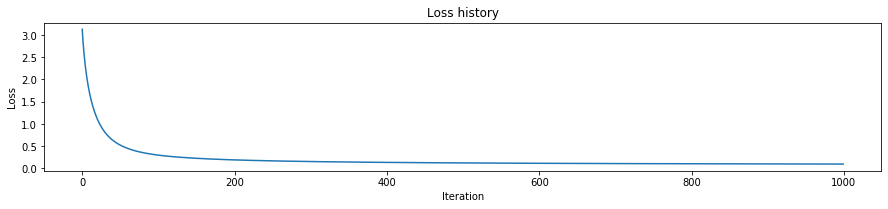

In [296]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

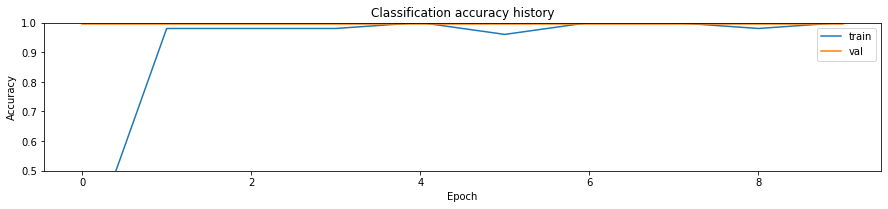

In [297]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot([accuracy]*len(stats['train_acc_history']), label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim((0.5, 1.0))
plt.show()

In [298]:
print(net.predict_one(X_test[0]))
print(y_test[0])

6
6


In [299]:
net.dump_data()

In [300]:
net_clone = NeuralNetworkClassifier(input_size, hidden_size, output_size)

In [301]:
net_clone.load_data()

In [302]:
print(net_clone.predict_one(X_test[0]))
print(y_test[0])

6
6
